In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Loading Data

In [5]:
df=pd.read_csv('C:\\Users\\travi\\Box Sync\\Code\\AirBnB Data\\listings.csv',delimiter=None)

# Cleaning Data

In [6]:
# I narrowed down the columns available as many, such as listing_url, weren't of interest to me 
# for the questions I plan on answering later in the notebook.

columns_of_interest=['neighbourhood_group_cleansed','property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
                     'reviews_per_month', 'square_feet', 'price', 'review_scores_rating', 'review_scores_accuracy',
                     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value']

# price needed to be cleaned as it was coming as an object rather than a quantitative variable. 
# The below website provided a useful technique
# https://pbpython.com/currency-cleanup.html

df['price']=df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
new_df=df[columns_of_interest]

In [7]:
#This shows the percent of each column with missing values.  As you might notice square_feet looks 
#particularily problematic

new_df.count()/new_df.shape[0]

neighbourhood_group_cleansed    1.000000
property_type                   0.999738
room_type                       1.000000
accommodates                    1.000000
bathrooms                       0.995809
bedrooms                        0.998428
beds                            0.999738
reviews_per_month               0.835778
square_feet                     0.025406
price                           1.000000
review_scores_rating            0.830540
review_scores_accuracy          0.827658
review_scores_cleanliness       0.828968
review_scores_checkin           0.827658
review_scores_communication     0.829492
review_scores_location          0.828444
review_scores_value             0.828182
dtype: float64

In [8]:
# Based on the cell above since there are very few missing volues except in square_feet I chose to drop the square_feet
# variable entirely and remove the missing rows for the rest of the variables

new_df.drop(columns=['square_feet'], inplace=True)
columns_of_interest.remove('square_feet')
cleaned_df=new_df.dropna(subset=columns_of_interest, how='any')

c:\users\travi\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Exploratory Analysis

## Heatmap Explained

Based on the above heatmap we can see a couple intersting things with the variables.  Accomodates, bedrooms, bathrooms,
and beds have a strong correlation with price.  While each one of these has a strong correlation with price they
also have a strong correlation with each other so it might be difficult for a model to determine which variable is
most important. 

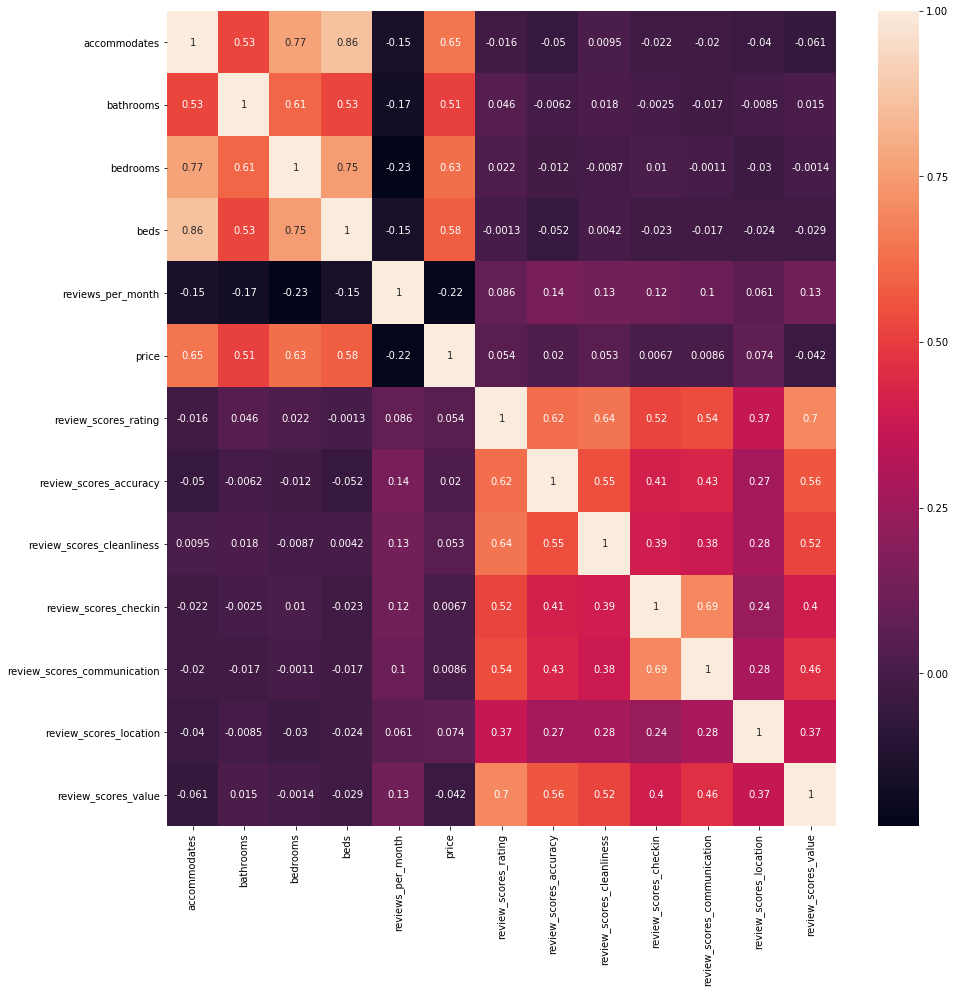

In [9]:

plt.subplots(figsize=(15,15))
sns.heatmap(cleaned_df.corr(), annot=True)

## Scatter Explained

As they say in real estate I location, location, location.  What I wanted to determine is if neighborhoods played a role in price.  We already know the accomodates variable is very important in explaining price so I used this variable on our scatter to control for the fact that some neighborhoods might have larger houses which exaplain the higher price rather than the neighborhood.  To create the scatter I used a mean price and accomodate variable.

As you can see by the scatter it looks like neighborhoods definitely can impact the price.  For example, you can see Queen Anne and Downtown neighborhoods are the most expensive compared to other neighborhoods that accomodate on average 3.5 people.

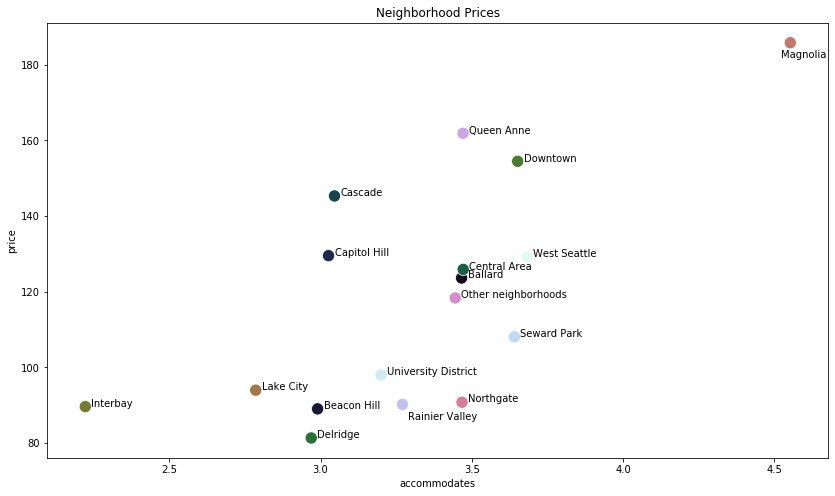

In [11]:
neighbor_df=cleaned_df.groupby('neighbourhood_group_cleansed')['price', 'accommodates'].mean()
plt.figure(figsize=(14, 8))
p1=sns.scatterplot(y='price', x='accommodates', data=neighbor_df, hue=neighbor_df.index, s=150, palette='cubehelix', legend=False)
p1.set_title('Neighborhood Prices')
for neighborhood, price, accomodates in zip(neighbor_df.index, neighbor_df['price'].values, neighbor_df['accommodates'].values):
    va_adj=0
    hor_adj=.02
    if neighborhood=='Rainier Valley':
        va_adj=4
    if neighborhood=='Magnolia':
        va_adj,hor_adj=4, -.03
    p1.text(accomodates+hor_adj, price-va_adj, 
    neighborhood, horizontalalignment='left', verticalalignment='baseline',
    size='medium', color='black', weight='normal')

# Preparing Data for Linear Regression

In [341]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [342]:
#We are using our created function to convert categorical variables into dummy variables so they can be used by our 
#upcoming linear regression model

cat_cols=cleaned_df.select_dtypes(include=['object']).columns
model_df=create_dummy_df(cleaned_df, cat_cols, False)

# Question 1: What Variables Effect the Price? - Train Linear Regression

After running the model on normalized data and looking at the coefficients we can see property type, neighborhood, and room type have the largest immpact. They represent all of the top 5 and bottom 5 variables.   

In [343]:
response_col='price'
y=model_df[response_col]
X=model_df.drop([response_col], axis=1)

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = .30, random_state=42)
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
test_score=r2_score(y_test, y_test_preds)
train_score=lm_model.score(X_train, y_train)

data={'col':X_test.columns, 'coef':lm_model.coef_ }
coef_data=pd.DataFrame.from_dict(data)
coef_data.sort_values('coef', ascending=False)

,col,coef
29,property_type_Boat,247.500819
41,property_type_Treehouse,56.913248
23,neighbourhood_group_cleansed_Queen Anne,38.641994
17,neighbourhood_group_cleansed_Downtown,34.438002
37,property_type_Loft,30.762193
14,neighbourhood_group_cleansed_Cascade,30.328239
2,bedrooms,29.636348
42,property_type_Yurt,26.289211
1,bathrooms,26.154107
31,property_type_Cabin,23.578210


# Question 2: What Neighborhoods are Customers Staying At?

In [12]:
#In order to figure out where people are staying we need to bring in the calendar data.  This will show bookings and 
#availability

calendar_df=pd.read_csv('C:\\Users\\travi\\Box Sync\\Code\\AirBnB Data\\calendar.csv',delimiter=None)
calendar_df['price']=calendar_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
calendar_df['date']=pd.to_datetime(calendar_df['date'])

#We created a new month column to determine if demand is higher in certain months
calendar_df['month'] = calendar_df['date'].dt.month

#Join with listing dataframe to bing in neighborhood data

listing_info_df=df[['id', 'price', 'neighbourhood_group_cleansed']]
cal_list_df=pd.merge(left=calendar_df, right=listing_info_df, left_on='listing_id', right_on='id', how='inner')

## Neighborhoods with Highest Bookings Rate

We can see that Cascade, Downtown, Capitol Hill and Queen Anne are the neighborhoods with the highest book rate percent.

[Text(0, 0.5, 'Percent Booked'), Text(0.5, 0, 'Neighborhood')]

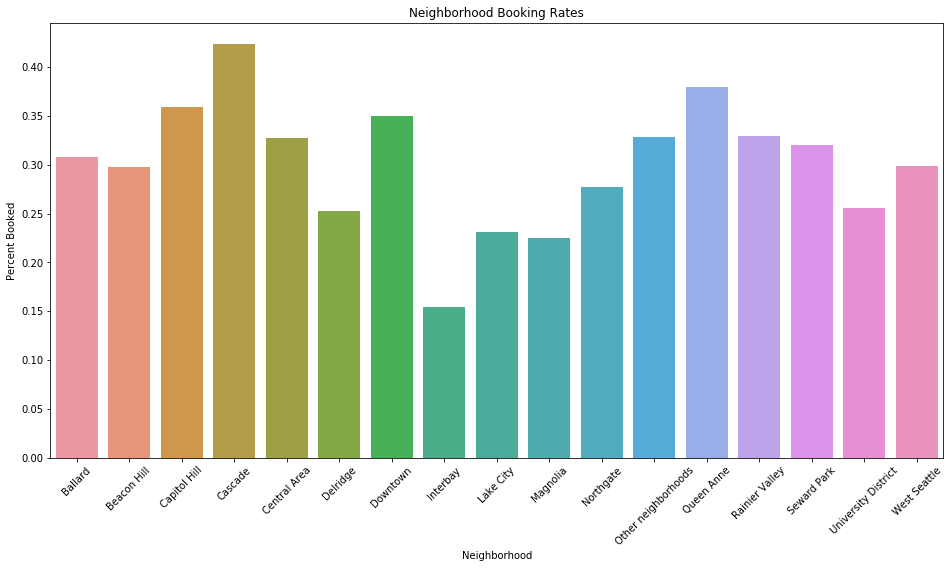

In [13]:
#Here I interpret 'f' in the available column to mean the property is booked.  I compare the ratio of book percent in 
#each neighborhood

stay_neighborhood=cal_list_df.groupby(['neighbourhood_group_cleansed', 'available'])['available'].count()/cal_list_df.groupby(['neighbourhood_group_cleansed'])['available'].count()
stay_neighborhood=stay_neighborhood.unstack()
stay_neighborhood.reset_index(inplace=True)
plt.figure(figsize=(16, 8))
plt.xticks(rotation=45)
book_rate=sns.barplot(x='neighbourhood_group_cleansed', y='f', data=stay_neighborhood)
book_rate.set_title('Neighborhood Booking Rates')
book_rate.set(xlabel='Neighborhood', ylabel='Percent Booked')

## Total Bookings Per Neighborhood

From a booking rate I can which neighborhoods have the highest booking rate percent.  Now I want to check from a total bookings perspective which are the most popular.

Ignoring the Other Neighborhoods category, because of the ambiguity, we can see that Downtown and Capitol Hill tend to be the
most popular neighborhoods to book as well as have a relative high booking rate.  One thing to note is Cascade has a high booking percent, but a low amount of total bookings.  The neighborhood could probably sustain a bit more supply of listings.

[Text(0, 0.5, 'Total Bookings'), Text(0.5, 0, 'Neighborhood')]

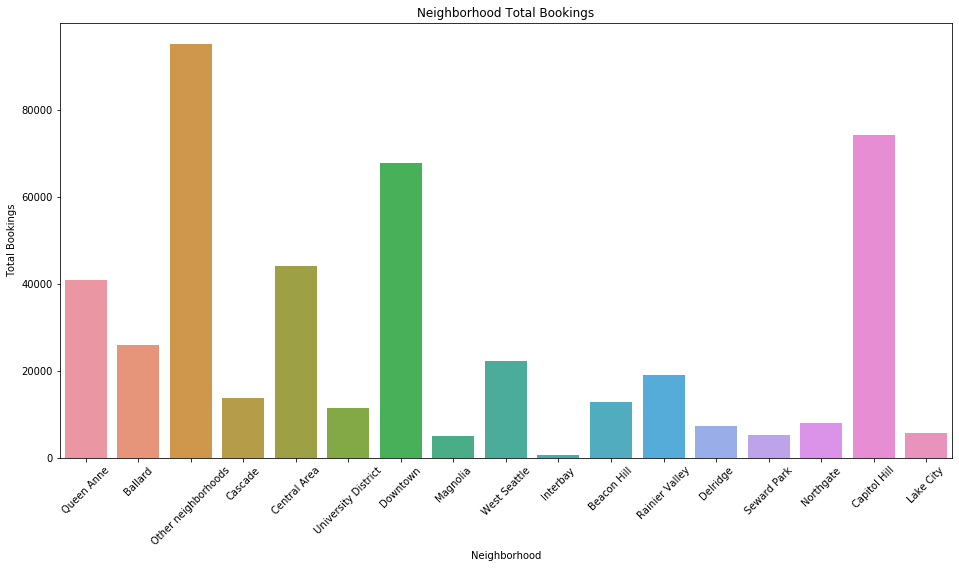

In [14]:
#Here I interpret 'f' in the available column to mean the property is booked.  I count them up to see how which 
#neighborhood has the highest total amount of bookings

plt.figure(figsize=(16, 8))
plt.xticks(rotation=45)
total_bookings=sns.countplot(x='neighbourhood_group_cleansed', data=cal_list_df[(cal_list_df['available']=='f')])
total_bookings.set_title('Neighborhood Total Bookings')
total_bookings.set(xlabel='Neighborhood', ylabel='Total Bookings')

# Qustion 3: Does Price and Demand Vary by Month?

## Booking Rate by Month

January (month 1) is a bit of outlier and needs to be ignored as the data was gathered in January so we would expect more bookings in that month. 

After ignoring the high booking rate in January we can see July and August have the highest booking percent even though they are months away.  We can probably interpret this to mean July and August are probably the high season for Seattle.

[Text(0, 0.5, 'Percent Booked'), Text(0.5, 0, 'Month')]

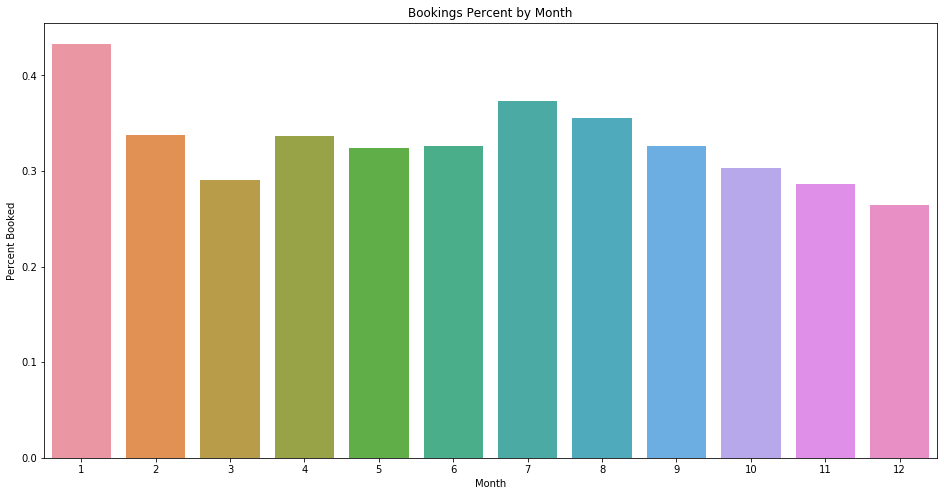

In [16]:
#Stay_moth dataframe is determining the book rate by month

stay_month=cal_list_df.groupby(['month', 'available'])['available'].count()/cal_list_df.groupby(['month'])['available'].count()
stay_month=stay_month.unstack()
stay_month.reset_index(inplace=True)
plt.figure(figsize=(16, 8))
rate_month=sns.barplot(x='month', y='f', data=stay_month)
rate_month.set_title('Bookings Percent by Month')
rate_month.set(xlabel='Month', ylabel='Percent Booked')

## Price by Month

We can see that there is dramatic upswing in prices as we get to the summer time in Seattle.  Interesting to note that both price and booking rate hit their peaks in the summer.  This data might suggest prices could be raised even higher before demand starts dropping off.

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Month')]

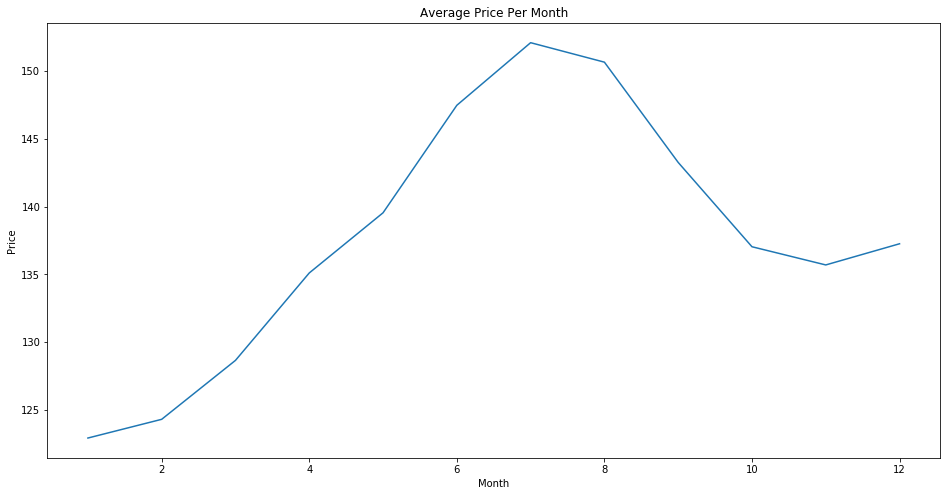

In [17]:
# Here we look at the available units and take the mean for their prices each month

cal_list_aval=cal_list_df[cal_list_df['available']=='t']
month_price=cal_list_aval.groupby('month')['price_x'].mean()
plt.figure(figsize=(16, 8))
price_month=sns.lineplot(x=month_price.index, y=month_price.values)
price_month.set_title('Average Price Per Month')
price_month.set(xlabel='Month', ylabel='Price')

# Question 4: Are There Deals to be Found in Peak Season?

By looking to at the price standard deviation of each listing we can see that 43% of the listings don't vary their prices at all each month.  They have a standard deviaiton of 0.  These units probably represent the best value for bookers.

In [349]:
#Here we find the standard deviation of price for each listing.  We want to see what percent of listings have a standard 
#deviation of 0 and don't vary their price.

list_month_price=cal_list_aval.groupby(['listing_id'])['price_x'].std()
np.sum(list_month_price==0)/list_month_price.shape[0]

0.4300295460650013